# Cleaning and Analysis #

## Import APIs ##

In [1]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wfdb
import ast

## Load data ##

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
sampling_rate=100

# load and convert annotation data
uncleaned_ptbxl_df = pd.read_csv('./ptb-xl/ptbxl_database.csv', index_col='ecg_id')
uncleaned_ptbxl_df.scp_codes = uncleaned_ptbxl_df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
raw_sig_data = load_raw_data(uncleaned_ptbxl_df, sampling_rate, './ptb-xl/')

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('./ptb-xl/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return str(list(set(tmp)))

# Apply diagnostic superclass
uncleaned_ptbxl_df['diagnostic_superclass'] = uncleaned_ptbxl_df.scp_codes.apply(aggregate_diagnostic)

## Cleaning Metadata ##

In [4]:
print(f'Shape of uncleaned PTB-XL database: {uncleaned_ptbxl_df.shape}\n')
print(f'Null values:\n{uncleaned_ptbxl_df.isnull().sum()}')

Shape of uncleaned PTB-XL database: (21799, 28)

Null values:
patient_id                          0
age                                 0
sex                                 0
height                          14825
weight                          12378
nurse                            1473
site                               17
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8468
infarction_stadium1             16187
infarction_stadium2             21696
validated_by                     9378
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20201
static_noise                    18539
burst_noise                     21186
electrodes_problems             21769
extra_beats                     19850
pacemaker                       21508
strat_fold                

In [5]:
# Drop unneeded columns from old dataframe
ptbxl_metadata = uncleaned_ptbxl_df.loc[:, ['age', 'sex', 'device', 'scp_codes', 'validated_by_human', 'diagnostic_superclass', 'filename_lr', 'filename_hr']].copy()

We chose to balance out classes by dropping records that had a diagnostic superclass of 'NORM' and other various classes (i.e. [NORM, CD, HYP]) because we didn't know what they meant, as well as dropping the last remaining abnormal ECG records to make the number of each class even.

In [6]:
uncleaned_ptbxl_df['diagnostic_superclass'].value_counts()

['NORM']                       9069
['MI']                         2532
['STTC']                       2400
['CD']                         1708
['CD', 'MI']                   1297
['STTC', 'HYP']                 781
['MI', 'STTC']                  595
['HYP']                         535
['CD', 'STTC']                  471
[]                              411
['CD', 'NORM']                  407
['MI', 'HYP', 'STTC']           358
['CD', 'HYP']                   300
['CD', 'MI', 'STTC']            223
['CD', 'STTC', 'HYP']           211
['MI', 'HYP']                   183
['CD', 'MI', 'HYP', 'STTC']     155
['CD', 'MI', 'HYP']             117
['STTC', 'NORM']                 28
['CD', 'STTC', 'NORM']            5
['STTC', 'MI']                    4
['CD', 'HYP', 'NORM']             2
['HYP', 'NORM']                   2
['STTC', 'HYP', 'MI']             2
['CD', 'STTC', 'HYP', 'MI']       1
['STTC', 'MI', 'HYP']             1
['CD', 'MI', 'HYP', 'NORM']       1
Name: diagnostic_superclass,

In [7]:
filtered_ptbxl_metadata = ptbxl_metadata[~ptbxl_metadata['diagnostic_superclass'].str.contains("'NORM',")]
filtered_ptbxl_metadata = filtered_ptbxl_metadata[~ptbxl_metadata['diagnostic_superclass'].str.contains(", 'NORM'")]

condition3 = filtered_ptbxl_metadata['diagnostic_superclass'].str.contains('NORM')
filtered_ptbxl_metadata.loc[condition3, 'diagnostic_superclass'] = 'NORMAL'
filtered_ptbxl_metadata.loc[~condition3, 'diagnostic_superclass'] = 'ABNORMAL'

print(filtered_ptbxl_metadata['diagnostic_superclass'].value_counts())

ABNORMAL    12285
NORMAL       9069
Name: diagnostic_superclass, dtype: int64


In [8]:
from sklearn.utils import resample

# Downsample majority class
abnormal_records = filtered_ptbxl_metadata[filtered_ptbxl_metadata['diagnostic_superclass'] == 'ABNORMAL']
normal_records = filtered_ptbxl_metadata[filtered_ptbxl_metadata['diagnostic_superclass'] == 'NORMAL']
downsampled_abnormal_records = resample(abnormal_records, 
                                replace=False,    # sample without replacement
                                n_samples=9069,   # to match minority class
                                random_state=123) # reproducible results

# Combine minority class with downsampled majority class
balanced_ptbxl_metadata = pd.concat([downsampled_abnormal_records, normal_records])

print(balanced_ptbxl_metadata['diagnostic_superclass'].value_counts())

ABNORMAL    9069
NORMAL      9069
Name: diagnostic_superclass, dtype: int64


In [9]:
balanced_ptbxl_metadata.head()

,age,sex,device,scp_codes,validated_by_human,diagnostic_superclass,filename_lr,filename_hr
ecg_id,,,,,,,,
5965,74.0,0,CS-12,"{'LAO/LAE': 100.0, 'ISCAL': 100.0, 'SR': 0.0}",True,ABNORMAL,records100/05000/05965_lr,records500/05000/05965_hr
6962,300.0,1,AT-6 C 5.5,"{'IPLMI': 100.0, 'QWAVE': 0.0, 'SR': 0.0}",True,ABNORMAL,records100/06000/06962_lr,records500/06000/06962_hr
15486,33.0,0,CS100 3,{'PACE': 100.0},False,ABNORMAL,records100/15000/15486_lr,records500/15000/15486_hr
2106,42.0,0,AT-6 C 5.8,"{'NDT': 100.0, 'NT_': 0.0, 'SR': 0.0}",True,ABNORMAL,records100/02000/02106_lr,records500/02000/02106_hr
16481,72.0,1,CS100 3,"{'LVH': 100.0, 'ISC_': 100.0, 'SR': 0.0}",False,ABNORMAL,records100/16000/16481_lr,records500/16000/16481_hr


In [10]:
# Generate new CSV files
file_name = "cleaned_ptbxl_metadata.csv"
target_file = os.path.join("./cleaned_data", file_name)
    
f = open(target_file, "w")
balanced_ptbxl_metadata.to_csv(f)
f.close()

## Waveform data ##

In [11]:
def create_waveform_df(record_path, segment_length=5000, start_index=0):
    # Load the waveform record and annotation
    record = wfdb.rdrecord(f'./ptb-xl/{record_path}')
    
    # Extract the signal and select a segment
    signal = record.p_signal[start_index:start_index + segment_length, :]
    time = np.arange(start_index, start_index + segment_length) / 500  # Create a time array in seconds
    
    waveform_df = pd.DataFrame(signal)
    waveform_df.index = time
    waveform_df.index.name = 'Time (s)'
    waveform_df.columns = record.sig_name
    
    return waveform_df

In [12]:
record_path = balanced_ptbxl_metadata['filename_hr'].iloc[0]
waveform_df = create_waveform_df(record_path)
waveform_df

,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,V5,V6
Time (s),,,,,,,,,,,,
0.000,0.120,0.495,0.375,-0.308,-0.128,0.435,0.145,0.295,0.490,0.735,0.820,0.395
0.002,0.120,0.495,0.375,-0.308,-0.128,0.435,0.145,0.295,0.490,0.735,0.820,0.395
0.004,0.119,0.495,0.376,-0.308,-0.129,0.435,0.145,0.295,0.489,0.734,0.818,0.394
0.006,0.122,0.495,0.373,-0.309,-0.126,0.434,0.145,0.296,0.491,0.739,0.825,0.397
0.008,0.117,0.495,0.379,-0.306,-0.132,0.437,0.146,0.294,0.487,0.727,0.811,0.391
...,...,...,...,...,...,...,...,...,...,...,...,...
9.990,-0.040,0.010,0.050,0.015,-0.045,0.030,-0.055,-0.090,-0.020,0.010,-0.035,-0.015
9.992,-0.040,0.010,0.050,0.015,-0.045,0.030,-0.055,-0.090,-0.020,0.010,-0.035,-0.015
9.994,-0.040,0.010,0.050,0.015,-0.045,0.030,-0.055,-0.090,-0.020,0.010,-0.035,-0.015


In [13]:
# Generated with the help of ChatGPT
def plot_waveform(record_path, segment_length=1000, start_index=0):
    """
    Function to plot a segment of an ECG waveform.

    Args:
    - record_name (str): The name of the record file without file extension.
    - segment_length (int): The number of samples to include in the plot.
    - start_index (int): The index of the first sample in the segment to plot.
    """
    # Load the waveform record and annotation
    record = wfdb.rdrecord(f'./ptb-xl/{record_path}')
    
    # Create waveform dataframe
    waveform_df = create_waveform_df(record_path)

    # Plot the signal
    plt.figure(figsize=(12, 6))
    for col in waveform_df.columns:
        plt.plot(waveform_df.index, waveform_df[col], label=f'Lead {col}')
    
    plt.title('ECG Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

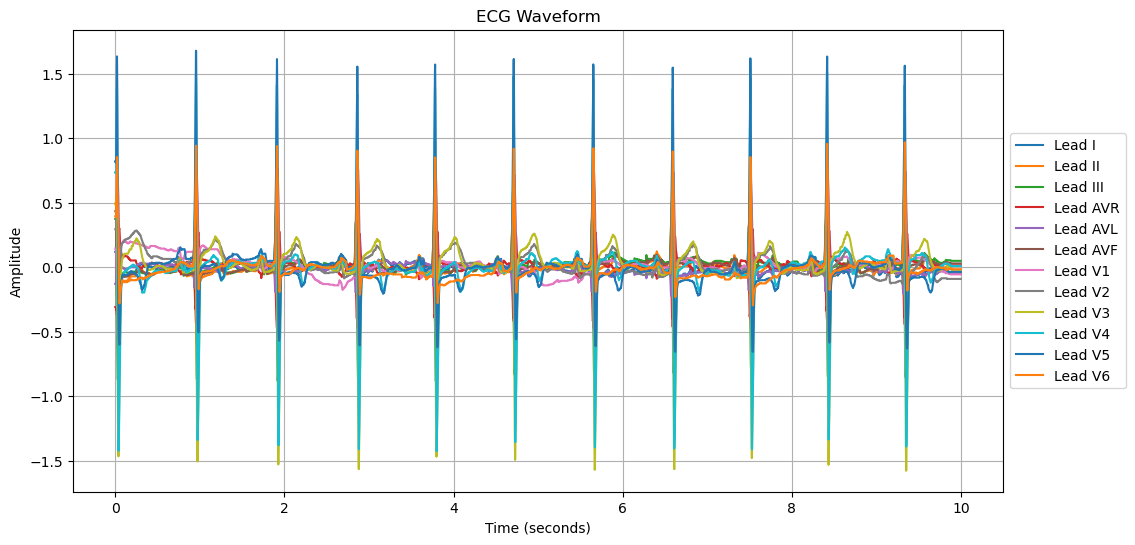

In [14]:
record_path = balanced_ptbxl_metadata['filename_hr'].iloc[0]
plot_waveform(record_path)

In [15]:
# Generate new CSV files
for ecg_id in balanced_ptbxl_metadata.index:
    ecg_record = balanced_ptbxl_metadata.loc[ecg_id]
    
    record_path = ecg_record['filename_hr']
    waveform_df = create_waveform_df(record_path)

    # Make new directory that corresponds to original record path
    new_dir = './cleaned_data/waveform_data/records500/' + record_path[11:16]
    os.makedirs(new_dir, exist_ok=True)
    file_name = record_path[-8:] + '.csv'
    target_file = os.path.join(new_dir, file_name)

    f = open(target_file, "w")
    waveform_df.to_csv(f)
    f.close()